<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/PINN_LaPlace2D_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Network

In [111]:
import torch
import torch.nn as nn

class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 2,
        num_layers: int = 3,
        num_neurons: int = 150,
        act: nn.Module = SineActivation(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

#network

# Example usage:
"""
model = LinearNN()
input_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features
output = model(input_tensor)

print("Input shape:", input_tensor)
print("Output shape:", output)"""

'\nmodel = LinearNN()\ninput_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features\noutput = model(input_tensor)\n\nprint("Input shape:", input_tensor)\nprint("Output shape:", output)'

#PINN Loss

In [141]:
import torch.nn.functional as F

def data_loss(predicted_data, target_data): #data has to be in z=0, 0<x<L
        #target data is obtained using behaviour function
        return F.mse_loss(predicted_data, target_data)

def boundary_condition_loss(boundary_conditions,output):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss
    return loss_bc

def pde_loss(model,input_data): #here input_data has to be in -h(x)<x2<0


    # Forward pass to get the function values
    output = model(input_data)
    pde_residuals=[]
    for o,d in zip(output,input_data):
      # Compute the Hessian matrix
      hessian = compute_hessian(o, d)
      # Extract elements corresponding to (0, 0) and (1, 1)
      hessian_00 = hessian[0, 0]
      hessian_11 = hessian[1, 1]

      pde_residuals.append(hessian_00+hessian_11)

    pde_residuals_tensor = torch.cat([residual.unsqueeze(0) for residual in pde_residuals])

    # Use torch.zeros_like with the tensor
    return F.mse_loss(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))

def compute_bc1(model,  x1,x2):

    x1_tensor = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
    x2_tensor = torch.tensor(x2, dtype=torch.float32 , requires_grad=True)

    # Concatenate x1 and x2 to form the input tensor
    input_tensor = torch.stack([x1_tensor, x2_tensor], dim=1)

    # Forward pass through the model
    output = model(input_tensor)

    # Compute the gradient with respect to x2
    grad_x2 = torch.autograd.grad(output, input_tensor,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 1]

    # Initialize a list to store the gradients for each element of x2_tensor
    #gradients_x2 = []

    # Compute the gradient for each element of output with respect to x2_tensor
    #for i in range(len(output)):
    #    grad_x2_element = torch.autograd.grad(output[i], x2_tensor[i], create_graph=True)[0]
    #    gradients_x2.append(grad_x2_element)

    # Stack the gradients into a tensor
    #grad_x2 = torch.stack(gradients_x2, dim=0)

    #print(f'Gradient bottom: {grad_x2}')
    return grad_x2

def compute_bc2(model, input_tensor):

    # Forward pass through the model
    output = model(input_tensor)

    #print(f'output: {output}')
    return output

def compute_hessian(output, input_data):
    hessian = autograd.hessian(lambda x: output, input_data)
    return hessian

#x1 and x2 have to represent the points we want to apply the constraints

#boundary_conditions = {
#    'bc1': compute_bc1(model, x1, -1),   # at x2=-1 the grad perpendicular to the bottom is null
#    'bc2_0': compute_bc2(model, 0, x2),  # at x1 = 0
#    'bc2_1': compute_bc2(model, 2, x2),  # at x1 = 2
#}

#total_loss = loss_data + loss_bc + loss_pde

#the data we provide to calculate each loss is extremely important. It has to belong to the domain where the constraints/pde/function are applied.

#Function approximation

In [113]:
import numpy as np

# General parameters
L = 2.0 # wave/x length
h = 1 # depth
T = 1 # period
H = 0.05 # surface wave amplitude (I chose it arbitrarliy. Check p. 68 HRC)
c = L/T # wave propagation velocity (p. 70 HCR)
k = 2*np.pi/L # wave nr.
w = 2*np.pi/T

t = 0 # we are looking at a snapshot, so t is constant

# Analytical solution (HRC p. 75)
def behaviour_func(x):
    return -H*c/2 * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

#Generate data

In [114]:
def  generate_data_function_approximation(size): #data generator for data loss and can also be used to train the network
  # Generate random values for x and t
    x1 = np.random.uniform(0, 2, size)
    x2 = np.zeros_like(x1)
    #t = np.random.uniform(0, 1, size)

    # Create input data by stacking x1, x2, and t
    #input_data = np.column_stack((x1, x2, t))
    input_data = np.column_stack((x1, x2))

    # Compute the corresponding function values using the analytical solution
    target_data = behaviour_func(input_data)

    return input_data, target_data



def generate_data_pde_loss(size):
    # Generate random values for x1 and x2 within the specified PDE domain
    x1 = np.random.uniform(0, L, size)
    x2 = np.random.uniform(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_periodic_boundary_data(size, x1_values):

    x1_0=np.full(size,x1_values[0]);
    x1_1=np.full(size,x1_values[1]);

    # Generate random values for x2 within the specified range for each x1
    x2 = np.random.uniform(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data_0=input_data = np.column_stack((x1_0, x2))
    input_data_1 = np.column_stack((x1_1, x2))

    return input_data_0,input_data_1
def generate_data_bottom_velocity(size):

    x2=np.full(size,-h);
    x1 = np.random.uniform(0, 2, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

#size = 10  # specify the desired size
#input_data, target_data = generate_data_z0(size)
#generate_pde_input_data(size)

#x1_values = np.array([0, 2])  # specify the x1 values
#input_data_0,input_data_1 = generate_periodic_boundary_data(size, x1_values)
#print(input_data_0,input_data_1)
#print(generate_bottom_velocity_data(10))

In [ ]:
import torch
import torch.nn as nn
import torch.autograd.functional as autograd

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Ensure the output is a scalar

def compute_hessian(output, input_data):
    print("Output shape:", output.shape)
    hessian = autograd.hessian(lambda x: output, input_data)
    return hessian

# Create an instance of the neural network
model = SimpleNN()

# Generate some random input data
input_data = torch.randn((10, 2), requires_grad=True)

print(input_data)
# Forward pass to get the function values
output = model(input_data)
print(output)

for o,data in zip(output,input_data):
  hessian = compute_hessian(o, data)
# Compute the Hessian matrix


print("Hessian matrix shape:", hessian.shape)



tensor([[-1.7665,  0.1505],
        [-0.2067, -0.3214],
        [ 1.4837,  0.7884],
        [ 0.9866,  2.0137],
        [-0.5232,  0.6135],
        [-0.5096, -0.5977],
        [ 0.1825,  1.4624],
        [ 1.5219,  3.3741],
        [ 1.3164, -1.7485],
        [-2.3434,  0.7998]], requires_grad=True)
tensor([[ 0.3215],
        [ 0.3186],
        [-0.0303],
        [-0.3350],
        [ 0.1046],
        [ 0.3678],
        [-0.1959],
        [-0.5217],
        [ 0.8424],
        [ 0.3112]], grad_fn=<AddmmBackward0>)
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Output shape: torch.Size([1])
Hessian matrix shape: torch.Size([2, 2])


In [115]:
import torch
import torch.nn as nn

# Define a simple neural network
class Simple2DNN(nn.Module):
    def __init__(self):
        super(Simple2DNN, self).__init__()
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc1(x)

# Instantiate the model
model = Simple2DNN()

# Create a 2D input tensor
x_input_2d = torch.tensor([[2.0, 3.0]], dtype=torch.float32, requires_grad=True)

# Forward pass through the model
output = model(x_input_2d)

# Compute the gradient with respect to the first dimension (index 0)
grad_input_1 = torch.autograd.grad(output, x_input_2d, grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 0]

# Print the results
print("Input Tensor (2D):")
print(x_input_2d)
print("\nOutput Tensor:")
print(output)
print("\nGradient with respect to the First Dimension:")
print(grad_input_1)



Input Tensor (2D):
tensor([[2., 3.]], requires_grad=True)

Output Tensor:
tensor([[1.7317]], grad_fn=<AddmmBackward0>)

Gradient with respect to the First Dimension:
tensor([0.1075], grad_fn=<SelectBackward0>)


#Training Loop

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_epochs = 1000
learning_rate = 0.0001
alpha = 1.0  # Weight for data loss
beta = 1.0   # Weight for boundary condition loss
gamma = 1.0  # Weight for PDE loss

# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_data_size=20
test_data_size=5
# Lists to store losses for plotting
loss_pde_list = []
loss_bc_list = []
loss_data_list = []
total_loss_list = []

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss(training_data_size)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)

# Lists to store test losses for plotting
test_loss_pde_list = []
test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list = []

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = model(torch.Tensor(input_data_function_approximation))

    # Compute losses
    loss_function_approximation = alpha * data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation))

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
    }

    loss_boundary_conditions = boundary_condition_loss(boundary_conditions,output)

    loss_pde_loss= pde_loss(model,torch.Tensor(input_data_pde_loss))

    # Total loss
    total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    loss_bc_list.append(loss_boundary_conditions.item())
    loss_data_list.append(loss_function_approximation.item())
    total_loss_list.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = alpha * data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
    }

    test_loss_boundary_conditions = boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_pde_loss = pde_loss(model, torch.Tensor(test_input_data_pde_loss))

    # Total test loss
    test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss

    # Append test losses to the lists
    test_loss_pde_list.append(test_loss_pde_loss.item())
    test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_total_loss_list.append(test_total_loss.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss.item()}')
        print("------------------------------------------------------------")
        print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')

# After training, you can use the trained model for predictions or further analysis


<ipython-input-124-10c8e85bbf44>:5: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(predicted_data, target_data)
<ipython-input-124-10c8e85bbf44>:10: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
<ipython-input-124-10c8e85bbf44>:5: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(predicted_data, target_data)


Streaming output truncated to the last 5000 lines.
output: tensor([-0.0013, -0.0009, -0.0014, -0.0014, -0.0013],
       grad_fn=<SqueezeBackward0>)
Gradient bottom: tensor([ 9.7068e-05, -5.6602e-05,  1.8858e-04, -2.3663e-04,  1.4145e-04,
        -1.1923e-04,  1.3573e-04, -6.0566e-05, -2.1666e-04, -2.4750e-04,
         1.8473e-04, -1.0415e-04, -1.3524e-05,  1.8427e-04,  6.0071e-05,
         1.6305e-05, -4.1637e-05,  1.4860e-04, -1.0418e-05, -2.4012e-05],
       grad_fn=<SelectBackward0>)
output: tensor([-0.0010, -0.0010, -0.0011, -0.0010, -0.0010, -0.0011, -0.0010, -0.0011,
        -0.0010, -0.0010, -0.0010, -0.0012, -0.0012, -0.0011, -0.0010, -0.0010,
        -0.0010, -0.0012, -0.0010, -0.0011], grad_fn=<SqueezeBackward0>)
output: tensor([-0.0008, -0.0009, -0.0011, -0.0008, -0.0011, -0.0013, -0.0007, -0.0013,
        -0.0010, -0.0007, -0.0009, -0.0014, -0.0014, -0.0012, -0.0006, -0.0010,
        -0.0009, -0.0014, -0.0011, -0.0013], grad_fn=<SqueezeBackward0>)
Gradient bottom: tensor([-

#Losses plots

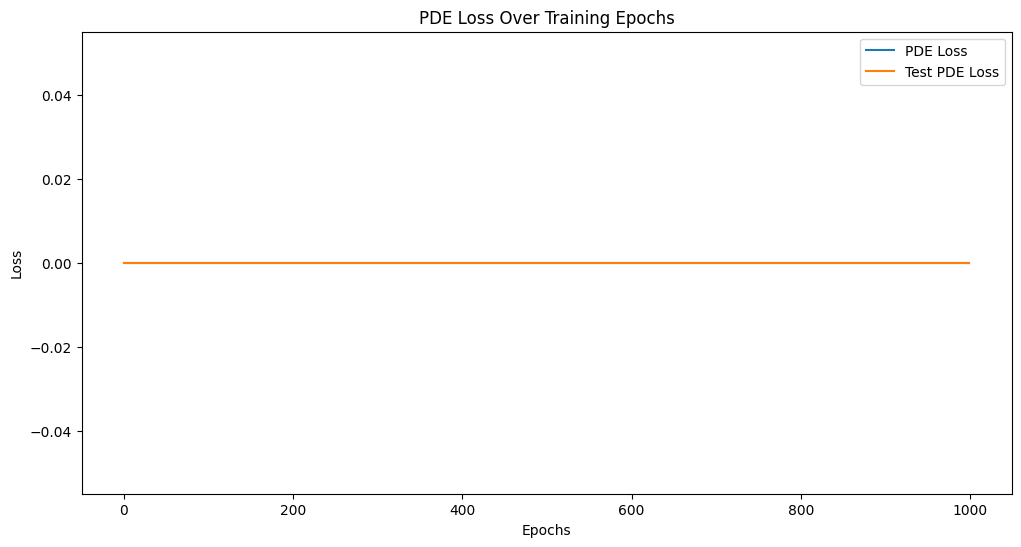

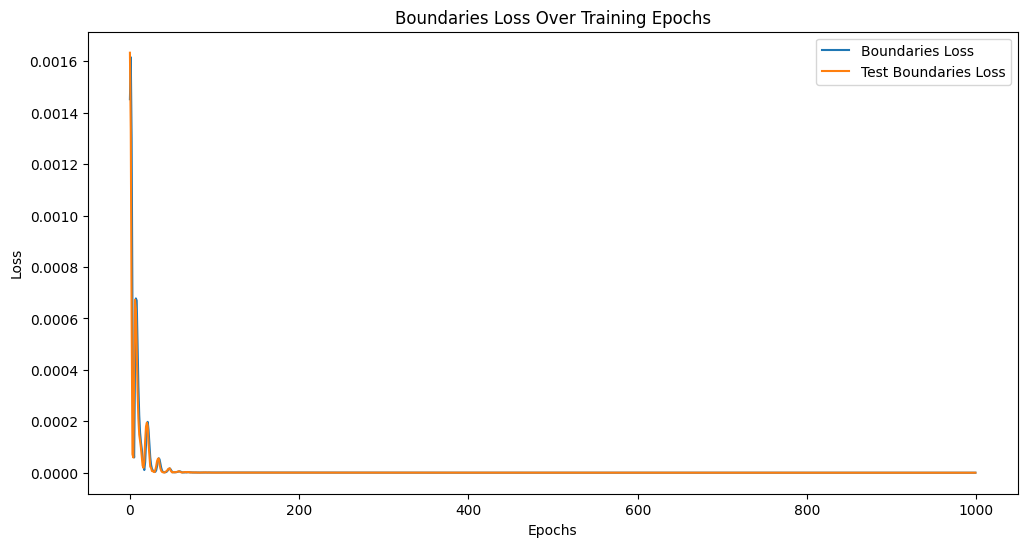

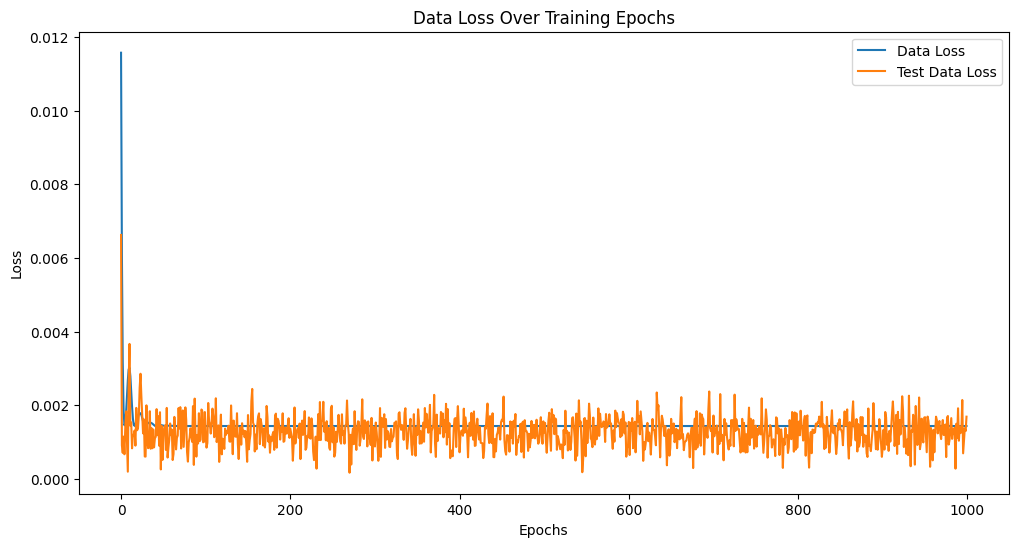

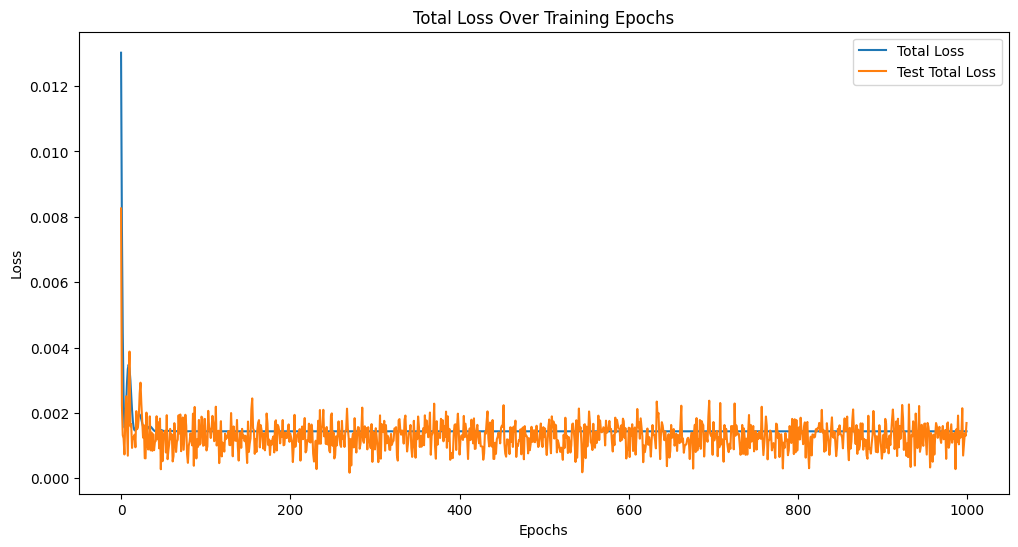

In [140]:
epochs_range = range(0, num_epochs, 1)
# Plotting PDE Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss_pde_list, label='PDE Loss')
plt.plot(epochs_range, test_loss_pde_list, label='Test PDE Loss')
plt.title('PDE Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Boundaries Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss_bc_list, label='Boundaries Loss')
plt.plot(epochs_range, test_loss_bc_list, label='Test Boundaries Loss')
plt.title('Boundaries Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Data Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss_data_list, label='Data Loss')
plt.plot(epochs_range, test_loss_data_list, label='Test Data Loss')
plt.title('Data Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Total Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, total_loss_list, label='Total Loss')
plt.plot(epochs_range, test_total_loss_list, label='Test Total Loss')
plt.title('Total Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#3D Plot with test data

In [195]:
total_test_data = []
test_data_size=50
#generate test data
test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

total_test_data.extend(test_input_data_function_approximation)
total_test_data.extend(test_input_data_boundary_conditions_0)
total_test_data.extend(test_input_data_boundary_conditions_1)
total_test_data.extend(test_input_data_pde_loss)
total_test_data.extend(test_input_data_vel_bottom)

# Convert the list to a PyTorch tensor
total_test_data = torch.Tensor(total_test_data)
output= model(torch.Tensor(total_test_data))

print(output.shape,(total_test_data.shape))

torch.Size([50]) torch.Size([50, 2])


In [163]:
x = total_test_data[:,0]
y = total_test_data[:,1]
print(x,y)

tensor([1.9649, 0.0207, 1.0935, 1.9903, 1.0120, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 1.2644, 0.7974, 0.7924,
        1.5149, 0.6937, 0.6082, 0.2171, 1.9555, 0.3091, 1.0447]) tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4510, -0.5917, -0.7995,
        -0.8055, -0.4016, -0.4510, -0.5917, -0.7995, -0.8055, -0.4016, -0.5168,
        -0.5825, -0.4984, -0.0431, -0.5121, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000])


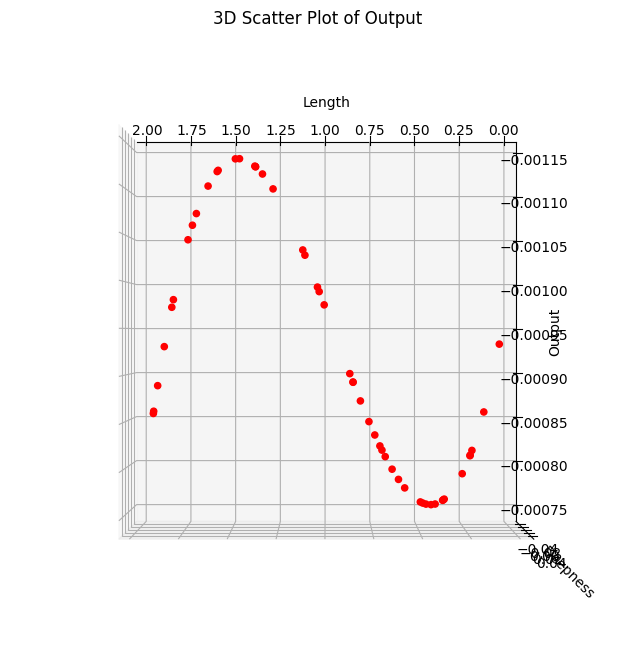

In [196]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = total_test_data[:,0]
y = total_test_data[:,1]
z = output.detach().numpy()  # Convert the torch Tensor to a NumPy array


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,z, y, c='r', marker='o')

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

ax.view_init(elev=90, azim=90)  # You can adjust the elev and azim values

# Show the plot
plt.show()
